In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle

import rksd.metrics as metrics
import rksd.kernels as kernels
import rksd.bootstrap as boot
import rksd.exp_utils as exp_utils
import rksd.ksdagg as src_ksdagg
import experiments.kef as exp_kef
import experiments.rbm as exp_rbm

plt.rcParams["mathtext.fontset"] = "cm"

# vs. contam ratio

In [16]:
n = 500
dim = 1
res_stats = pickle.load(open(f"../data/bw/eps_stats_n{n}_d{dim}.pkl", "rb"))

bw_ls = list(res_stats.keys())
print(bw_ls)
ol_ls = list(res_stats[bw_ls[0]].keys())
ol = ol_ls[0]
print(ol_ls)
eps_ls = list(res_stats[bw_ls[0]][ol].keys())
print(eps_ls)

['med', 0.01, 0.1, 1.0, 10.0, 100.0]
[10.0]
[0.0, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


In [17]:
res_stats[bw][ol].keys()

dict_keys([0.0, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

In [21]:
methods = {"standard": "IMQ", "tilted_r_boot": "R-KSD"}

plot_df = {"eps": [], "method": [], "rej": [], "bw": [], "bw_order": []}
for bw in bw_ls[1:]:
    for eps in eps_ls:
        for m, m_label in methods.items():
            rr = res_stats[bw][ol][eps][m]
            plot_df["eps"].extend([eps] * len(rr["nonsq_stat"]))
            
            plot_df["rej"].extend(rr["rej"])
            plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))
            plot_df["bw"].extend([bw] * len(rr["nonsq_stat"]))
            plot_df["bw_order"].extend([np.round(np.log(bw) / np.log(10.), 2)] * len(rr["rej"]))

plot_df = pd.DataFrame(plot_df)

# med heuristic
m = "tilted_r_boot"
med_plot_df = {"eps": [], "method": [], "rej": []}
for eps in eps_ls:
    rr = res_stats["med"][ol][eps][m]
    med_plot_df["eps"].extend([eps] * len(rr["rej"]))
    
    med_plot_df["rej"].extend(rr["rej"])
    med_plot_df["method"].extend(["med"] * len(rr["rej"]))

med_plot_df = pd.DataFrame(med_plot_df)

# ksdagg
ksdagg_plot_df = {"eps": [], "method": [], "rej": []}
for eps in eps_ls:
    rr = res_stats[bw_ls[0]][ol][eps]["ksdagg"]
    ksdagg_plot_df["eps"].extend([eps] * len(rr["rej"]))
    
    ksdagg_plot_df["rej"].extend(rr["rej"])
    ksdagg_plot_df["method"].extend(["KSDAgg"] * len(rr["rej"]))

ksdagg_plot_df = pd.DataFrame(ksdagg_plot_df)

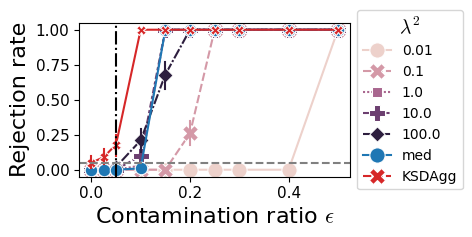

In [29]:
eps0 = 0.05
plot_df = plot_df.loc[plot_df.eps <= 0.5]
med_plot_df = med_plot_df.loc[med_plot_df.eps <= 0.5]
ksdagg_plot_df = ksdagg_plot_df.loc[ksdagg_plot_df.eps <= 0.5]

_, ax = plt.subplots(figsize=(3.5, 2))

g1 = sns.lineplot(ax=ax, data=plot_df.loc[plot_df.method == "R-KSD"], 
                  x="eps", y="rej", hue="bw_order", style="bw_order", markers=True, err_style="bars", markersize=11)
lines = ax.get_lines()
line_colors = [line.get_color() for line in lines]
g2 = sns.lineplot(
    ax=ax, data=med_plot_df, x="eps", y="rej", style="method", markers=True, err_style="bars", color="C0", markersize=9)
g3 = sns.lineplot(
    ax=ax, data=ksdagg_plot_df, x="eps", y="rej", style="method", markers=["X"], err_style="bars", color="C3", linestyle="--", markersize=7)
ax.axvline(eps0, color="k", linestyle="-.", label=r"$\epsilon_0$")
ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
ax.set_xlabel(r"Contamination ratio $\epsilon$", fontsize=16)
ax.set_ylabel("Rejection rate", fontsize=16)
ax.tick_params(axis="both", labelsize=11)

lg = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), labels=bw_ls[1:]+["med", "KSDAgg"], title=r"$\lambda^2$")
lg.get_lines()[-2].set_color("C0")
lg.get_lines()[-1].set_color("C3")
lg.set_title(r"$\lambda^2$", prop={"size": 14})

plt.savefig("../figs/bw_rksd.pdf", bbox_extra_artists=(lg,), bbox_inches="tight")

# vs. outlier

In [33]:
n = 500
dim = 1
res_stats = pickle.load(open(f"../data/bw/ol_stats_n{n}_d{dim}.pkl", "rb"))

bw_ls = list(res_stats.keys())
print(bw_ls)
ol_ls = list(res_stats[bw_ls[0]].keys())
print(ol_ls)
eps_ls = list(res_stats[bw_ls[0]][ol_ls[0]].keys())
eps_ls

['med', 0.01, 0.1, 1.0, 10.0, 100.0]
[0.1, 1.0, 10.0, 25.0, 50.0, 100.0]


[0.05]

In [34]:
methods = {"standard": "IMQ", "tilted_r_boot": "R-KSD-Boot"}
# methods = {"standard": "IMQ"}
eps = eps_ls[0]

plot_df_ls = []
for m, m_label in methods.items():
    plot_df = {"ol": [], "method": [], "rej": [], "bw": [], "bw_order": []}
    
    for bw in bw_ls[1:]:
        for ol in ol_ls:        
            rr = res_stats[bw][ol][eps][m]
            plot_df["ol"].extend([ol] * len(rr["nonsq_stat"]))
            
            plot_df["rej"].extend(rr["rej"])
            plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))
            plot_df["bw"].extend([bw] * len(rr["nonsq_stat"]))
            plot_df["bw_order"].extend([np.round(np.log(bw) / np.log(10.), 2)] * len(rr["rej"]))

    plot_df_ls.append(pd.DataFrame(plot_df))

# med heuristic
med_plot_df_ls = []
for m, m_label in methods.items():
    med_plot_df = {"ol": [], "method": [], "rej": []}
    for ol in ol_ls:
        rr = res_stats["med"][ol][eps][m]
        med_plot_df["ol"].extend([ol] * len(rr["rej"]))
        
        med_plot_df["rej"].extend(rr["rej"])
        med_plot_df["method"].extend(["med"] * len(rr["rej"]))
    
    med_plot_df_ls.append(pd.DataFrame(med_plot_df))

# ksdagg
ksdagg_plot_df = {"ol": [], "method": [], "rej": []}
for ol in ol_ls:
    rr = res_stats[bw_ls[0]][ol][eps]["ksdagg"]
    ksdagg_plot_df["ol"].extend([ol] * len(rr["rej"]))
    
    ksdagg_plot_df["rej"].extend(rr["rej"])
    ksdagg_plot_df["method"].extend(["KSDAgg"] * len(rr["rej"]))

ksdagg_plot_df = pd.DataFrame(ksdagg_plot_df)

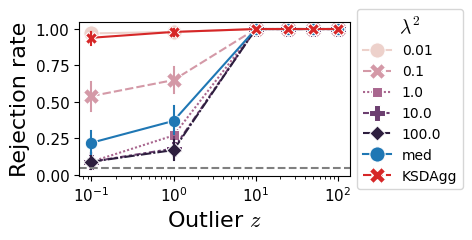

In [37]:
plot_df = plot_df_ls[0]
med_plot_df = med_plot_df_ls[0]

_, ax = plt.subplots(figsize=(3.5, 2))

g1 = sns.lineplot(ax=ax, data=plot_df, x="ol", y="rej", hue="bw_order", style="bw_order", markers=True, err_style="bars", markersize=11)
g2 = sns.lineplot(
    ax=ax, data=med_plot_df, x="ol", y="rej", style="method", markers=True, err_style="bars", color="C0", markersize=9)
g3 = sns.lineplot(
    ax=ax, data=ksdagg_plot_df, x="ol", y="rej", style="method", markers=["X"], err_style="bars", color="C3", linestyle="--", markersize=9)
ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
ax.set_xlabel(r"Outlier $z$", fontsize=16)
ax.set_ylabel("Rejection rate", fontsize=16)
ax.tick_params(axis="both", labelsize=11)
ax.set_xscale("log")

lg = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), labels=bw_ls[1:]+["med", "KSDAgg"])
lg.get_lines()[-2].set_color("C0")
lg.get_lines()[-1].set_color("C3")
lg.set_title(r"$\lambda^2$", prop={"size": 14})

plt.savefig("../figs/bw.pdf", bbox_extra_artists=(lg,), bbox_inches="tight")